In [38]:
from twitterscraper import query_tweets
import datetime as dt 
import pandas as pd 
import cld3
import re
from collections import Counter
from wordcloud import WordCloud

#Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [55]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from matplotlib import pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/moby/nltk_data...


In [3]:
def fetch_tweets(query, start_date, end_date, limit = 10000, language = "English"):
    """
    start_date: date in form year,month,day
    """

    tweets = query_tweets(query, begindate = start_date, enddate = end_date, limit = limit, lang = language)
    df = pd.DataFrame(t.__dict__ for t in tweets)
    return df

In [ ]:
start_date = dt.date(2019,10,1)
end_date = dt.date(2020,4,30)
query = "coronavirus OR covid OR covid19 OR covid-19 OR corona virus OR #COVID19, OR #CoronavirusOutbreak" 
tweets = fetch_tweets("covid-19, OR corona virus", start_date, end_date, language = 'english')

INFO: queries: ['covid-19, OR corona virus since:2019-10-01 until:2019-10-11', 'covid-19, OR corona virus since:2019-10-11 until:2019-10-22', 'covid-19, OR corona virus since:2019-10-22 until:2019-11-01', 'covid-19, OR corona virus since:2019-11-01 until:2019-11-12', 'covid-19, OR corona virus since:2019-11-12 until:2019-11-23', 'covid-19, OR corona virus since:2019-11-23 until:2019-12-03', 'covid-19, OR corona virus since:2019-12-03 until:2019-12-14', 'covid-19, OR corona virus since:2019-12-14 until:2019-12-24', 'covid-19, OR corona virus since:2019-12-24 until:2020-01-04', 'covid-19, OR corona virus since:2020-01-04 until:2020-01-15', 'covid-19, OR corona virus since:2020-01-15 until:2020-01-25', 'covid-19, OR corona virus since:2020-01-25 until:2020-02-05', 'covid-19, OR corona virus since:2020-02-05 until:2020-02-15', 'covid-19, OR corona virus since:2020-02-15 until:2020-02-26', 'covid-19, OR corona virus since:2020-02-26 until:2020-03-08', 'covid-19, OR corona virus since:2020-0

In [86]:
tweets.shape

(5472, 21)

In [5]:
#Extract language of each tweet 
tweets['language'] = tweets['text'].apply(cld3.get_language).map(lambda x: x[0])

In [6]:
tweets[['text', 'language']]

,text,language
0,El recorte no habla nada de genocidio. Fueron ...,es
1,Esta demostrado que mas de 95% de las muertes ...,es
2,Momcilo ima neki corona virus i sad ne sme da ...,bs
3,Que se mejore prontito. Que prueben a ver si e...,es
4,Hajam hone k liye kuch baaten waisi ho tou. .....,jv
...,...,...
5468,"गांव पहुंचे 3 मजदूरों को नहीं मिली एंट्री, सड़...",hi
5469,"tem que ficar mais, tá perigoso eu não quero q...",pt
5470,Yo que vos espero antes la cura de corona virus,es
5471,A vontade é de pega uma caixa colocar corona v...,pt


In [7]:
english_tweets = tweets[tweets['language']=='en']
english_tweets[['text', 'language']]

,text,language
6,Hi! I love meeting people that really loves an...,en
13,Hi! I love meeting people that really loves an...,en
24,"Hi. Blondie, my sister Molly, and many others ...",en
26,I had a kitty who contracted corona virus and ...,en
27,West Nile Virus Update:\n\nThere were two West...,en
...,...,...
5451,Honestly keep up restrictions until there are ...,en
5454,Aus Gov secured 10million COVID-19 test kits &...,en
5459,Sir @jidesanwoolu you have been awesome since ...,en
5466,What do I miss most about life before the coro...,en


In [8]:
stemmer=PorterStemmer()

stop = stopwords.words('english')

In [32]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\s{2,}', " ", text)
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", "not ", text)
    text = re.sub(r"i'm", "I am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    text = ' '.join([word for word in text.split() if word not in (stop)])
    words=re.split("\\s+",text)
    stemmed_words=[stemmer.stem(word=word) for word in words]
    
    return ' '.join(stemmed_words)

In [33]:
english_tweets['prep_text'] = english_tweets['text'].apply(preprocess)

In [34]:
english_tweets['prep_text']

6       hi love meet peopl realli love anim know mani ...
13      hi love meet peopl realli love anim know mani ...
24      hi blondi sister molli mani other share hous y...
26      kitti contract corona viru kidney diseas live ...
27      west nile viru updat two west nile viru posit ...
                              ...                        
5451    honestli keep restrict activ case app keep us ...
5454    au gov secur 10million covid 19 test kit patho...
5459    sir jidesanwoolu awesom sinc begin corona viru...
5466                           miss life corona viru 2015
5467    truli heartbreak stori got someth eye bill ref...
Name: prep_text, Length: 1996, dtype: object

In [39]:
word_to_list = [word for line in english_tweets['prep_text'] for word in line.split()]
word_to_list[:20]

['hi', 'love', 'meet', 'peopl', 'realli', 'love', 'anim', 'know', 'mani', 'fake', 'feral', 'cat', 'steal', 'heart', 'miss', 'much', 'love', 'cat', 'corona', 'viru']

## Plotting Word Occurrence

In [ ]:
occurence = Counter(word_to_list).most_common(50)
occurence_df = pd.DataFrame(occurence, columns=['stemmed_word', 'frequency'])

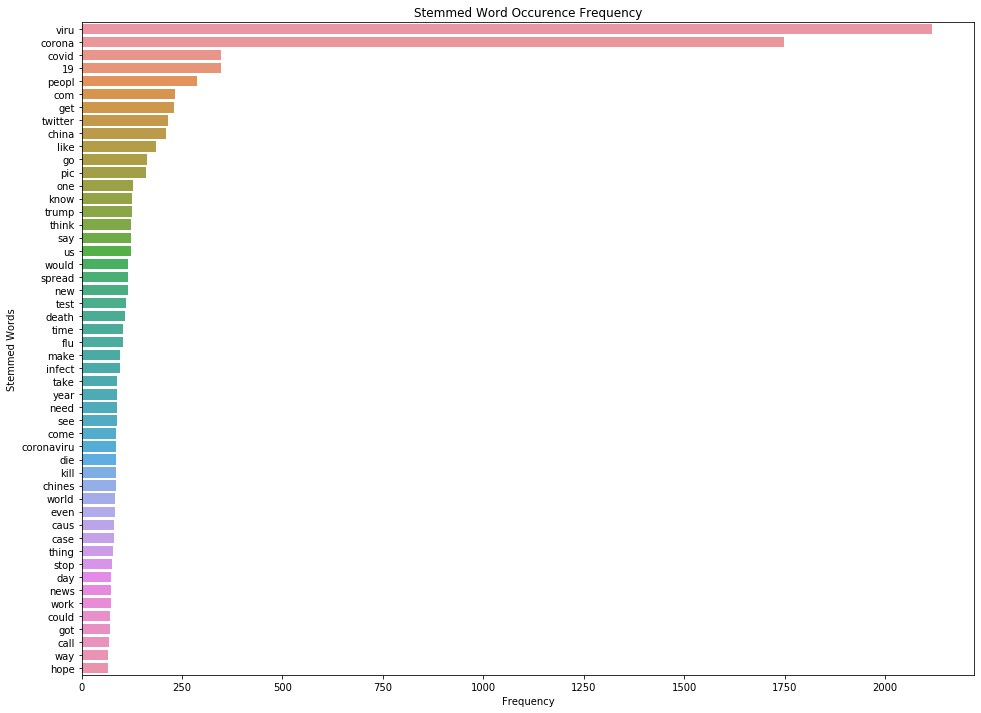

In [40]:
fig, ax = plt.subplots(figsize = (16, 12))
ax = sns.barplot(y="stemmed_word", x='frequency', 
                 ax = ax, data=occurence_df
                    ).set(title = "Stemmed Word Occurence Frequency", xlabel = 'Frequency', ylabel = 'Stemmed Words' )

## Plotting the Word Cloud

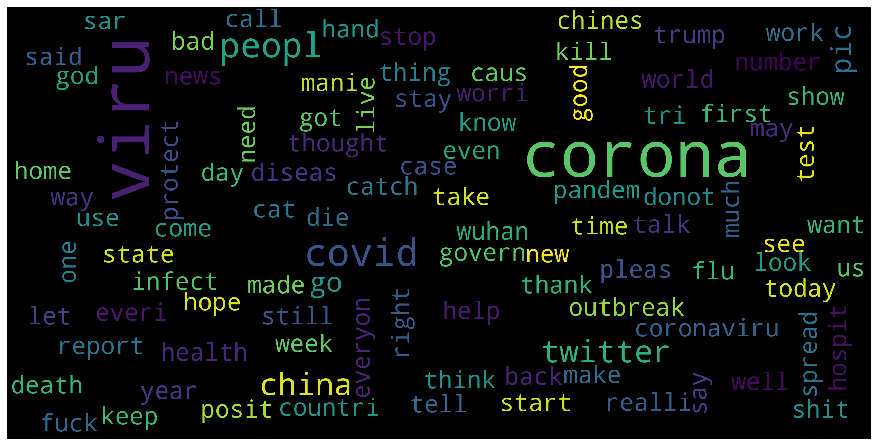

In [51]:
wordcloud = WordCloud(
    max_words=100,
    width=500,
    height=250,
    max_font_size=40, 
    scale=5,
    random_state=2,
    collocations=False,
    normalize_plurals=False
)

wordcloud.generate(' '.join(word_to_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Running Sentiment Analysis

In [70]:
#polarity score for each tweet
sia_object = SentimentIntensityAnalyzer()
polarity_scores = english_tweets['prep_text'].apply(lambda x: sia_object.polarity_scores(x))

polarity_scores_df = pd.DataFrame(list(polarity_scores))
polarity_scores_df.head()

,neg,neu,pos,compound
0,0.185,0.422,0.393,0.8979
1,0.185,0.422,0.393,0.8979
2,0.000,0.782,0.218,0.4404
3,0.000,0.653,0.347,0.7845
4,0.000,1.000,0.000,0.0000


## Categorizing sentiments as positive, negative or neutral

In [71]:
polarity_scores_df['sentiment'] = polarity_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
polarity_scores_df.head()


,neg,neu,pos,compound,sentiment
0,0.185,0.422,0.393,0.8979,positive
1,0.185,0.422,0.393,0.8979,positive
2,0.000,0.782,0.218,0.4404,positive
3,0.000,0.653,0.347,0.7845,positive
4,0.000,1.000,0.000,0.0000,neutral


In [82]:
sentiment_counts = pd.DataFrame.from_dict(Counter(polarity_scores_df['sentiment']), orient = 'index').reset_index()
sentiment_counts.columns = ['sentiment', 'frequency']
sentiment_counts

,sentiment,frequency
0,positive,668
1,neutral,488
2,negative,840


## Plotting sentiment frequency

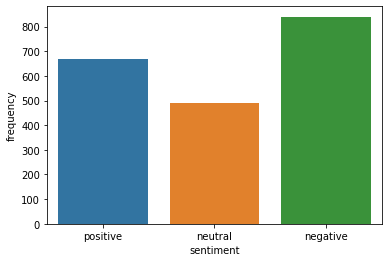

In [84]:
sns.barplot(y="frequency", x='sentiment', data=sentiment_counts).set
plt.show()